In [1]:
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F

os.environ["DGLBACKEND"] = "pytorch"
import dgl
from dgl.dataloading import GraphDataLoader
from dgl.data import DGLDataset
import h5py
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from dgl.nn.pytorch.conv import GINConv
from dgl.nn.pytorch.glob import SumPooling, AvgPooling, MaxPooling
from tqdm.notebook import tqdm
from dgl.data.utils import save_graphs, load_graphs

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
data_comsic = h5py.File(
    "/home2/hky/github/Gamma_Energy/AllSky_originData/Data/Comsic_allsky_compress_cuted.h5",
    "r",
)
data_gamma = h5py.File(
    "/home2/hky/github/Gamma_Energy/AllSky_originData/Data/gamma_allsky_compress_cuted.h5",
    "r",
)
loc = np.loadtxt(
    "/home2/hky/github/Gamma_Energy/AllSky_originData/TibetIII-forplot.loc"
)

In [4]:
data_comsic = {key:data_comsic[key][:] for key in data_comsic}
data_gamma = {key:data_gamma[key][:] for key in data_gamma}

In [5]:
data = {key:np.concatenate([data_comsic[key],data_gamma[key]],axis=0) for key in data_gamma.keys()}

In [6]:
data["isgamma"] = np.ones_like(data["prie"])
data["isgamma"][:len(data_comsic["prie"])]=0

In [7]:
del data_comsic
del data_gamma

In [8]:
train_val_index, test_index = train_test_split(
    range(len(data["prie"])), random_state=42, test_size=0.8
)
train_index, val_index = train_test_split(
    train_val_index, random_state=42, test_size=0.3
)

In [18]:
def create_graph(savepath, save_index, k):
    Tibet = data["Tibet"][save_index]
#     prie = torch.tensor(
#         np.log10(data["prie"][:][save_index] / 1000), dtype=torch.float32
#     )
    isgamma = torch.tensor(data["isgamma"][save_index], dtype=torch.long)
#     phi = torch.tensor(data["priphi"][:][save_index], dtype=torch.float32)
    graphs = list()
    for index in tqdm(range(len(isgamma))):
        particle_num = Tibet[index, :, 0]
        time = Tibet[index, :, 1]
        need = np.where((particle_num >= 0.4) & (np.abs(time) < 800))
        nnode = len(need[0])
        xdata = np.zeros([nnode, 4], dtype=np.float32)
        xdata[:, 0] = np.log10(particle_num[need])
        xdata[:, 1] = time[need] / 500
        xdata[:, 2] = loc[need][:, 3] / 75
        xdata[:, 3] = loc[need][:, 4] / 75

        #         src = np.array([n for n in range(nnode) for _ in range(nnode)], dtype=np.int32)
        #         dst = np.array(list(range(nnode)) * nnode, dtype=np.int32)
        #         need_del = np.where(src == dst)
        #         src = np.delete(src, need_del[0])
        #         dst = np.delete(dst, need_del[0])
        #         src = torch.tensor(src)
        #         dst = torch.tensor(dst)
        xdata = torch.from_numpy(xdata)
        g = dgl.knn_graph(xdata[:, 2:], k=k)
        g.ndata["xdata"] = xdata
        graphs.append(g)
    save_graphs(savepath, graphs, {"isgamma": isgamma})

In [19]:
for k in range(10, 11):
    savepath = f"/cxtmp/hky/ICRCdata/cosmic_gamma_train_dgl_knn_{k}.bin"
    create_graph(savepath, train_index, k)
    savepath = f"/cxtmp/hky/ICRCdata/cosmic_gamma_val_dgl_knn_{k}.bin"
    create_graph(savepath, val_index, k)

  0%|          | 0/291860 [00:00<?, ?it/s]

  0%|          | 0/125084 [00:00<?, ?it/s]

In [20]:
savepath = f"/cxtmp/hky/ICRCdata/cosmic_gamma_test_dgl_knn_10.bin"
create_graph(savepath, test_index, 10)

  0%|          | 0/1667780 [00:00<?, ?it/s]

In [12]:
class Gamma_Allsky_dgl(DGLDataset):
    def __init__(self, path):
        self.graph, self.labels = load_graphs(path)

    def __len__(self):
        return len(self.graph)

    def __getitem__(self, index):
        return (self.graph[index], self.labels["isgamma"][index])

In [10]:
class MLP(nn.Module):
    """Construct two-layer MLP-type aggreator for GIN model"""

    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.linears = nn.ModuleList()
        # two-layer MLP
        self.linears.append(nn.Linear(input_dim, hidden_dim, bias=False))
        self.linears.append(nn.Linear(hidden_dim, output_dim, bias=False))
        self.batch_norm = nn.BatchNorm1d((hidden_dim))

    def forward(self, x):
        h = x
        h = F.relu(self.batch_norm(self.linears[0](h)))
        return self.linears[1](h)


class GIN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.ginlayers = nn.ModuleList()
        self.batch_norms = nn.ModuleList()
        num_layers = 5
        # five-layer GCN with two-layer MLP aggregator and sum-neighbor-pooling scheme
        for layer in range(num_layers - 1):  # excluding the input layer
            if layer == 0:
                mlp = MLP(input_dim, hidden_dim, hidden_dim)
            else:
                mlp = MLP(hidden_dim, hidden_dim, hidden_dim)
            self.ginlayers.append(
                GINConv(mlp, learn_eps=False)
            )  # set to True if learning epsilon
            self.batch_norms.append(nn.BatchNorm1d(hidden_dim))
        # linear functions for graph sum poolings of output of each layer
        self.linear_prediction = nn.ModuleList()
        for layer in range(num_layers):
            if layer == 0:
                self.linear_prediction.append(nn.Linear(input_dim, output_dim))
            else:
                self.linear_prediction.append(nn.Linear(hidden_dim, output_dim))
        self.drop = nn.Dropout(0.5)
        self.pool = (
            MaxPooling()
        )  # change to mean readout (AvgPooling) on social network datasets

    def forward(self, g, h):
        # list of hidden representation at each layer (including the input layer)
        hidden_rep = [h]
        for i, layer in enumerate(self.ginlayers):
            h = layer(g, h)
            h = self.batch_norms[i](h)
            h = F.relu(h)
            hidden_rep.append(h)
        score_over_layer = 0
        # perform graph sum pooling over all nodes in each layer
        for i, h in enumerate(hidden_rep):
            pooled_h = self.pool(g, h)
            score_over_layer += self.drop(self.linear_prediction[i](pooled_h))
        return score_over_layer


In [6]:
model_name = ["GIN"]
result = dict()

k = 10
train_path = f"/cxtmp/hky/ICRCdata/cosmic_gamma_train_dgl_knn_{k}.bin"
val_path = f"/cxtmp/hky/ICRCdata/cosmic_gamma_val_dgl_knn_{k}.bin"

MCdataset_train = Gamma_Allsky_dgl(train_path)
MCdataset_val = Gamma_Allsky_dgl(val_path)

In [7]:
train_dataloader = GraphDataLoader(
    MCdataset_train, batch_size=256, drop_last=False, num_workers=4, shuffle=True
)
val_dataloader = GraphDataLoader(
    MCdataset_val, batch_size=256, drop_last=False, num_workers=4, shuffle=False
)

In [ ]:
test = next(iter(train_dataloader))
test[0].to(device)

for i, modeltype in enumerate([GIN]):
    val_loss_best = 1
    model = modeltype(4, 16, 2).to(device)
    maxtpoch = 80
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=5e-4)
    lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, maxtpoch)
    lossfunction = nn.CrossEntropyLoss()

    for epoch in range(maxtpoch):
        model.train()
        for batched_graph, labels in train_dataloader:
            if batched_graph.num_edges() > 2e8:
                continue
            batched_graph, labels = batched_graph.to(device), labels.to(
                device
            )
            pred = model(batched_graph, batched_graph.ndata["xdata"])
            loss = lossfunction(pred, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
#             print(loss)
        lr_scheduler.step()
        y_pred = list()
        y_orgin = list()
        model.eval()
        with torch.no_grad():
            for batched_graph, labels in val_dataloader:
                if batched_graph.num_edges() > 2e8:
                    continue
                batched_graph, labels = batched_graph.to(device), labels.to(device)
                pred = model(batched_graph, batched_graph.ndata["xdata"])
                y_pred.append(pred.cpu().numpy())
                y_orgin.append(labels.cpu().numpy())
        y_pred = np.concatenate(y_pred,axis=0)
        y_orgin = np.concatenate(y_orgin)
        val_loss =lossfunction(torch.from_numpy(y_pred),torch.from_numpy(y_orgin))
#             print(val_loss)
        if val_loss < val_loss_best:
            val_loss_best = val_loss
            torch.save(
                model.state_dict(), f"/cxtmp/hky/ICRCdata/{model_name[i]}_{k}_Adam_P_gamma.pt"
            )
            result[f"{model_name[i]}_{k}"] = val_loss_best
            print(f"{epoch} {model_name[i]}_{k}", val_loss_best)

0 GIN_10 tensor(0.2375)
1 GIN_10 tensor(0.1859)
2 GIN_10 tensor(0.1522)
3 GIN_10 tensor(0.1342)
4 GIN_10 tensor(0.1274)
5 GIN_10 tensor(0.1176)
7 GIN_10 tensor(0.1135)
8 GIN_10 tensor(0.1104)
10 GIN_10 tensor(0.1051)
12 GIN_10 tensor(0.1035)
15 GIN_10 tensor(0.1027)
16 GIN_10 tensor(0.1018)
18 GIN_10 tensor(0.1006)
19 GIN_10 tensor(0.0972)
24 GIN_10 tensor(0.0968)
25 GIN_10 tensor(0.0958)
26 GIN_10 tensor(0.0925)
30 GIN_10 tensor(0.0909)
35 GIN_10 tensor(0.0902)
40 GIN_10 tensor(0.0882)
44 GIN_10 tensor(0.0866)
46 GIN_10 tensor(0.0859)
47 GIN_10 tensor(0.0850)
49 GIN_10 tensor(0.0837)
58 GIN_10 tensor(0.0825)
61 GIN_10 tensor(0.0822)
63 GIN_10 tensor(0.0812)
64 GIN_10 tensor(0.0809)
68 GIN_10 tensor(0.0806)


In [ ]:
# val_loss_list =list()
# for i in result.keys():
#     val_loss_list.append(result[i])

In [13]:
test_path = f"/cxtmp/hky/ICRCdata/cosmic_gamma_test_dgl_knn_{10}.bin"

MCdataset_test = Gamma_Allsky_dgl(test_path)

test_dataloader = GraphDataLoader(
    MCdataset_test, batch_size=256, drop_last=False, num_workers=4, shuffle=False
)

In [15]:
test = next(iter(test_dataloader))
test[0].to(device)

model = GIN(4, 16, 2).to(device)
model.load_state_dict(torch.load( f"/cxtmp/hky/ICRCdata/GIN_MaxPooling_10_Adam_P_gamma.pt"))
model.eval()
y_pred = list()
y_orgin = list()
with torch.no_grad():
    for batched_graph, labels in test_dataloader:
        if batched_graph.num_edges() > 2e8:
            continue
        batched_graph, labels = batched_graph.to(device), labels.to(device)
        pred = model(batched_graph, batched_graph.ndata["xdata"])
        y_pred.append(pred.cpu().numpy())
        y_orgin.append(labels.cpu().numpy())
y_pred = np.concatenate(y_pred,axis=0)
y_orgin = np.concatenate(y_orgin)
# val_loss = np.mean((y_pred - y_orgin) ** 2)

/home2/hky/miniconda3/envs/dgl/lib/python3.9/site-packages/dgl/backend/pytorch/tensor.py:449: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


In [33]:
y_pred_softmax = F.softmax(torch.from_numpy(y_pred),dim=1).numpy()

In [34]:
np.where(y_orgin==0)

(array([      8,      13,      15, ..., 1667719, 1667746, 1667772]),)

(array([1444383.,   62925.,   24852.,   14477.,   10246.,    8232.,
           7364.,    7525.,    9194.,   78582.]),
 array([5.67905389e-10, 1.00000001e-01, 2.00000003e-01, 3.00000012e-01,
        4.00000006e-01, 5.00000000e-01, 6.00000024e-01, 6.99999988e-01,
        8.00000012e-01, 8.99999976e-01, 1.00000000e+00]),
 <BarContainer object of 10 artists>)

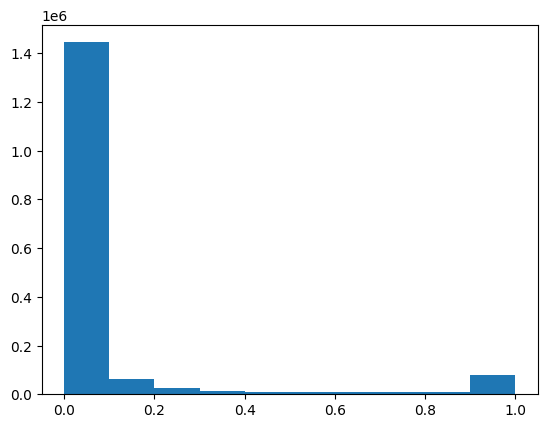

In [35]:
plt.hist(y_pred_softmax[:,0])

In [36]:
newdata = dict()
for para in data:
    if para not in ["Tibet","MD"]:
        newdata[para] = data[para][:][test_index]
newdata["GIN_isgamma"] = y_pred_softmax[:,1]

In [37]:
newdata

{'age': array([0.6621716 , 0.40195089, 1.00317541, ..., 0.47301493, 0.5467048 ,
        0.66254008]),
 'cx': array([ 89.65108939,  33.10925904, -23.08883435, ..., -74.4910488 ,
         20.23831716, -23.48962163]),
 'cy': array([  73.72972958,   74.39151343,  -82.4879488 , ..., -104.89825902,
          28.25490733,   53.88214838]),
 'inout': array([1, 1, 1, ..., 1, 1, 1], dtype=int32),
 'mr1': array([62.60599485, 36.86808622, 34.94326397, ..., 54.83033709,
        24.29729784, 40.10490748]),
 'nch': array([121,  21,  23, ...,  65,  25, 159], dtype=int32),
 'ne': array([256400.68560789,  16404.12643241,  15613.15052031, ...,
        315195.070374  ,  14192.43420226, 147398.16305941]),
 'phi': array([175.03215172, 102.70807947, 105.20823935, ...,  80.73259227,
         37.36662295,  40.10778827]),
 'pricx': array([ 92.419,  35.154, -23.45 , ..., -74.67 ,  17.245, -24.929]),
 'pricy': array([  72.97 ,   74.924,  -91.459, ..., -103.08 ,   34.204,   54.309]),
 'prie': array([301876.6875    

In [38]:
np.savez(f"/cxtmp/hky/ICRCdata/cosmic_gamma_test_with_dgl.npz",**newdata)

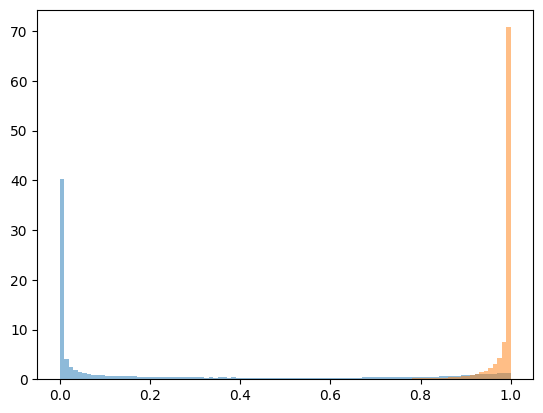

In [44]:
plt.hist(newdata["GIN_isgamma"][np.where(y_orgin==0)],bins=np.linspace(0,1,101),alpha=0.5,density=True)
plt.hist(newdata["GIN_isgamma"][np.where(y_orgin==1)],bins=np.linspace(0,1,101),alpha=0.5,density=True)
plt.show()